### Introduction



#### 1. Mean normalization

Mean normalization is just removing the mean from each observation.

$$
\bs{X'} = \bs{X} - \bar{x}
$$

where $\bs{X'}$ is the normalized dataset, $\bs{X}$ the original dataset and $\bar{x}$ the mean of $\bs{X}$.

It will have the effect of centering the data around 0. We will create the function `center()` to do that:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['axes.edgecolor'] = '#D6D6D6'
plt.rcParams['axes.linewidth'] = 2

In [3]:
def center(X):
    newX = X - np.mean(X, axis = 0)
    return newX

In [8]:
def plotDataAndCov(data):
    ACov = np.cov(data, rowvar=False, bias=True)
    print('Covariance matrix:\n', ACov)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(10, 10)

    ax0 = plt.subplot(2, 2, 1)
    
    # Choosing the colors
    cmap = sns.color_palette("GnBu", 10)
    sns.heatmap(ACov, cmap=cmap, vmin=0)

    ax1 = plt.subplot(2, 2, 2)
    
    # data can include the colors
    if data.shape[1]==3:
        c=data[:,2]
    else:
        c="#0A98BE"
    ax1.scatter(data[:,0], data[:,1], c=c, s=40)
    
    # Remove the top and right axes from the data plot
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

Covariance matrix:
 [[0.95171641 0.92932561]
 [0.92932561 1.12683445]]


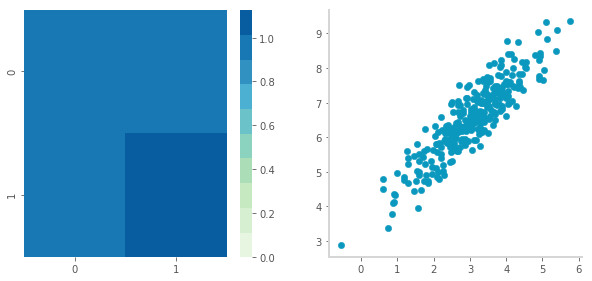

In [9]:
np.random.seed(1234)
b1 =  np.random.normal(3, 1, 300)
b2 = b1 + np.random.normal(7, 1, 300)/2.
B = np.array([b1, b2]).T
plotDataAndCov(B)
plt.show()
plt.close()

Let's give it a try with the matrix $\bs{B}$ we have created above:

Before:


Covariance matrix:
 [[0.95171641 0.92932561]
 [0.92932561 1.12683445]]


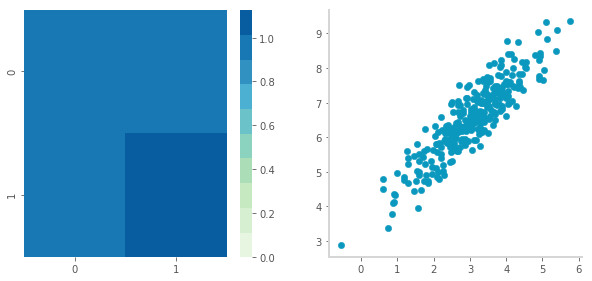

After:


Covariance matrix:
 [[0.95171641 0.92932561]
 [0.92932561 1.12683445]]


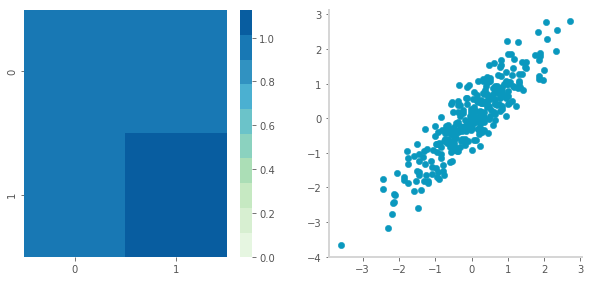

In [10]:
BCentered = center(B)

print('Before:\n\n') 

plotDataAndCov(B)
plt.show()
plt.close()

print('After:\n\n')

plotDataAndCov(BCentered)
plt.show()
plt.close()

The first plot shows again the original data $\bs{B}$ and the second plot shows the centered data (look at the scale).

#### 2. Standardization

The standardization is used to put all features on the same scale. The way to do it is to divide each zero-centered dimension by its standard deviation.

$$
\bs{X'} = \frac{\bs{X} - \bar{x}}{\sigma_{\bs{X}}}
$$

where $\bs{X'}$ is the standardized dataset, $\bs{X}$ the original dataset, $\bar{x}$ the mean of $\bs{X}$ and $\sigma_{\bs{X}}$ the standard deviation of $\bs{X}$.

In [324]:
def standardize(X):
    newX = center(X)/np.std(X, axis = 0)
    return newX

Let's create another dataset with a different scale to check that it is working.

Covariance matrix:
[[ 0.95171641  0.83976242]
 [ 0.83976242  6.22529922]]


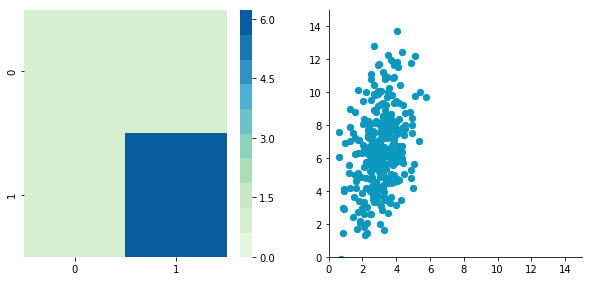

In [325]:
np.random.seed(1234)
c1 =  np.random.normal(3, 1, 300)
c2 = c1 + np.random.normal(7, 5, 300)/2.
C = np.array([c1, c2]).T

plotDataAndCov(C)
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.show()
plt.close()

We can see that the scales of $x$ and $y$ are different. Note also that the correlation seems smaller because of the scale differences. Now let's standardise it:

Covariance matrix:
[[ 1.          0.34500274]
 [ 0.34500274  1.        ]]


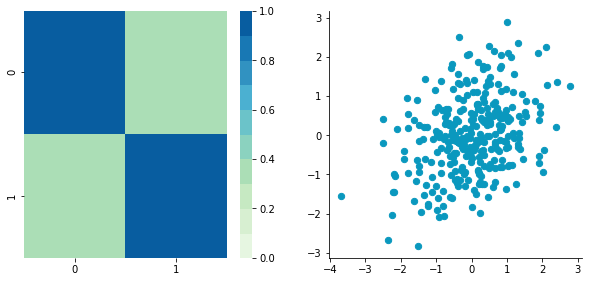

In [326]:
CStandardized = standardize(C)

plotDataAndCov(CStandardized)
plt.show()
plt.close()

Looks good! You can see that the scales are the same and that the dataset is zero-centered according to both axes. Now, have a look at the covariance matrix: you can see that the variance of each coordinate (the top-left cell and the bottom-right cell) is equal to 1. By the way, this new covariance matrix is actually the correlation matrix!💥 The Pearson correlation coefficient between the two variables ($\bs{c1}$ and $\bs{c2}$) is 0.54220151.

#### 3.1. Whitening

Whitening or sphering data means that we want to transform it in a way to have a covariance matrix that is the identity matrix (1 in the diagonal and 0 for the other cells; [more details on the identity matrix](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.3-Identity-and-Inverse-Matrices/)). It is called whitening in reference to white noise.

Whitening is a bit more complicated but we now have all the tools that we need to do it. It involves the following steps:

    1- Zero-center the data
    2- Decorrelate the data
    3- Rescale the data
    
Let's take again $\bs{C}$ and try to do these steps.

#### 1. Zero-centering

Covariance matrix:
[[ 0.95171641  0.83976242]
 [ 0.83976242  6.22529922]]


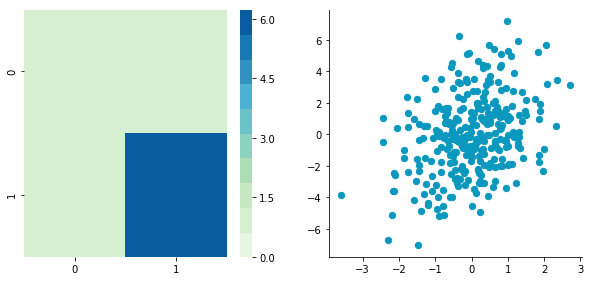

In [327]:
CCentered = center(C)

plotDataAndCov(CCentered)
plt.show()
plt.close()

#### 2. Decorrelate

At this point, we need to decorrelate our data. Intuitively, it means that we want to rotate the data until there is no correlation anymore. 

So we can decorrelate the data by projecting it on the eigenvectors basis. This will have the effect to apply the rotation needed and remove correlations between the dimensions. Here are the steps:

    1- Calculate the covariance matrix
    2- Calculate the eigenvectors of the covariance matrix
    3- Apply the matrix of eigenvectors to the data (this will apply the rotation)
    
Let's pack that into a function:

In [279]:
def decorrelate(X):
    newX = center(X)
    cov = X.T.dot(X)/float(X.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    return decorrelated

Let's try to decorrelate our zero-centered matrix $\bs{C}$ to see it in action:

Covariance matrix:
[[ 0.95171641  0.83976242]
 [ 0.83976242  6.22529922]]


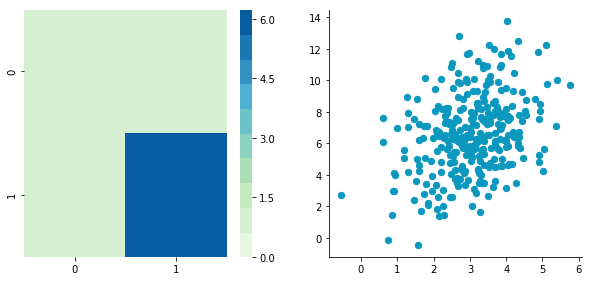

Covariance matrix:
[[  5.96126981e-01  -1.48029737e-16]
 [ -1.48029737e-16   3.15205774e+00]]


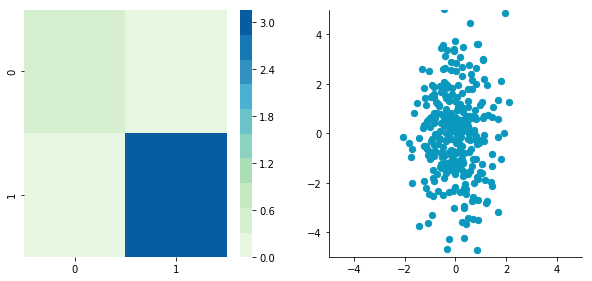

In [276]:
plotDataAndCov(C)
plt.show()
plt.close()

CDecorrelated = decorrelate(CCentered)
plotDataAndCov(CDecorrelated)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()
plt.close()

Nice! This is working 🎄

We can see that the correlation is not here anymore and that the covariance matrix (now a diagonal matrix) confirms that the covariance between the two dimensions is equal to 0.

#### 3. Rescale the data

The next step is to scale the uncorrelated matrix in order to obtain a covariance matrix corresponding to the identity matrix (ones on the diagonal and zeros on the other cells). To do that we scale our decorrelated data by dividing each dimension by the square-root of its corresponding eigenvalue.

In [280]:
def whiten(X):
    newX = center(X)
    cov = X.T.dot(X)/float(X.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    # Rescale the decorrelated data
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened

*Note:* we add a small value (here $10^{-5}$) to avoid the division by $0$.

Covariance matrix:
[[  9.99983225e-01  -1.06581410e-16]
 [ -1.06581410e-16   9.99996827e-01]]


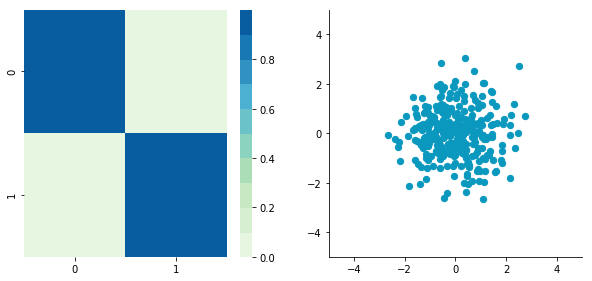

In [281]:
CWhitened = whiten(CCentered)

plotDataAndCov(CWhitened)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()
plt.close()